# Note:
The simulated data will be output as a csv after running the DGP for each option (my laptop didn't have enough room to store the data unfortunately, but the code is there to create the files).

In [289]:
import pandas as pd
import numpy as np
import random
import statsmodels.api as sm
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
import matplotlib.pyplot as plt
import networkx as nx
from tqdm import tqdm
random.seed(10)

In [290]:
def fn_variance(data, ddof=0):
    n = len(data)
    mean = sum(data) / n
    return sum((x - mean) ** 2 for x in data) / (n - ddof)

def fn_generate_cov(dim):
    acc  = []
    for i in range(dim):
        row = np.ones((1,dim)) * corr
        row[0][i] = 1
        acc.append(row)
    return np.concatenate(acc,axis=0)

def fn_generate_multnorm(nobs,corr,nvar):

    mu = np.zeros(nvar)
    std = (np.abs(np.random.normal(loc = 1, scale = .5,size = (nvar,1))))**(1/2)
    # generate random normal distribution
    acc = []
    for i in range(nvar):
        acc.append(np.reshape(np.random.normal(mu[i],std[i],nobs),(nobs,-1)))
    
    normvars = np.concatenate(acc,axis=1)

    cov = fn_generate_cov(nvar)
    C = np.linalg.cholesky(cov)

    Y = np.transpose(np.dot(C,np.transpose(normvars)))

#     return (Y,np.round(np.corrcoef(Y,rowvar=False),2))
    return Y

def fn_randomize_treatment(N,p=0.5):
    treated = random.sample(range(N), round(N*p))
    return np.array([(1 if i in treated else 0) for i in range(N)]).reshape([N,1])

def fn_randomize_selection(N,p=0.5):
    selected = random.sample(range(N), round(N*p))
    return np.array([(1 if i in selected else 0) for i in range(N)]).reshape([N,1])


def fn_generate_data(tau,sB_mult,N,p,p0,corr,sBias,conf = True,flagX = False):
    """
    p0(int): number of covariates with nonzero coefficients
    """
    nvar = p+2 # 1 confounder and variable for randomizing treatment
    corr = 0.5 # correlation for multivariate normal

    if conf==False:
        conf_mult = 0 # remove confounder from outcome
    else: conf_mult = 1 # otherwise, don't!
    
    allX = fn_generate_multnorm(N,corr,nvar)
    W0 = allX[:,0].reshape([N,1]) # variable for RDD assignment
    C = allX[:,1].reshape([N,1]) # confounder
    X = allX[:,2:] # observed covariates
    
    T = fn_randomize_treatment(N) # choose treated units
    S = fn_randomize_selection(N) # generate mediator (selection bias) variable
    err = np.random.normal(0,1,[N,1])
    beta0 = np.random.normal(5,5,[p,1])
    
    beta0[p0:p] = 0 # sparse model
    Yab = tau*T + sB_mult*S + X@beta0 + conf_mult*0.6*C + err
    if flagX==False and sBias==False:
        return (Yab,T)
    elif flagX==False and sBias==True:
        return (Yab,T,S)
    elif flagX==True and sBias==False:
        return (Yab,T,X)
    else:
        return (Yab,T,X,S)

def fn_tauhat_means(Yt,Yc):
    nt = len(Yt)
    nc = len(Yc)
    tauhat = np.mean(Yt)-np.mean(Yc)
    se_tauhat = ((np.var(Yt,ddof=1)/nt)+(np.var(Yc,ddof=1)/nc))**(1/2)
    return (tauhat,se_tauhat)

def fn_bias_rmse_size(theta0,thetahat,se_thetahat,cval = 1.96):
    """
    theta0 - true parameter value
    thetatahat - estimated parameter value
    se_thetahat - estiamted se of thetahat
    """
    b = thetahat - theta0
    bias = np.mean(b)
    rmse = np.sqrt(np.mean(b**2))
    tval = b/se_thetahat # paramhat/se_paramhat H0: theta = 0
    size = np.mean(1*(np.abs(tval)>cval))
    # note size calculated at true parameter value
    return (bias,rmse,size)

def fn_run_experiments(tau,sB_mult,sBias,Nrange,p,p0,corr,conf,flagX):
    n_values = []
    tauhats = []
    sehats = []
    lb = []
    ub = []
    for N in tqdm(Nrange):
        n_values = n_values + [N]
        if flagX==False and sBias==False:
            Yexp,T = fn_generate_data(tau,sB_mult,N,p,p0,corr,sBias,conf,flagX)
            Yt = Yexp[np.where(T==1)[0],:]
            Yc = Yexp[np.where(T==0)[0],:]
            tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)
        elif flagX==True and sBias==False:
            # control for covariates, don't control for mediator variable
            Yexp,T,X = fn_generate_data(tau,sB_mult,N,p,p0,corr,sBias,conf,flagX)
            Xobs = X[:,:p0]
            covars = np.concatenate([T,Xobs],axis = 1)
            mod = sm.OLS(Yexp,covars)
            res = mod.fit()
            tauhat = res.params[0]
            se_tauhat = res.HC1_se[0]
        elif flagX==False and sBias==True:
            # don't control for covariates, do control for mediator variable
            Yexp,T,S = fn_generate_data(tau,sB_mult,N,p,p0,corr,sBias,conf,flagX)
            Yt = Yexp[np.where((T==1) & (S==1))[0],:]
            Yc = Yexp[np.where((T==0) & (S==1))[0],:]
            tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)
        else:
            # control for both covariates and mediator variable
            Yexp,T,X,S = fn_generate_data(tau,sB_mult,N,p,p0,corr,sBias,conf,flagX)
            Xobs = X[:,:p0]
            covars = np.concatenate([T,Xobs,S],axis = 1)
            mod = sm.OLS(Yexp,covars)
            res = mod.fit()
            tauhat = res.params[0]
            se_tauhat = res.HC1_se[0]
            
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]    
        lb = lb + [tauhat-1.96*se_tauhat]
        ub = ub + [tauhat+1.96*se_tauhat]
        
    return (n_values,tauhats,sehats,lb,ub)


def fn_plot_with_ci(n_values,tauhats,tau,lb,ub,caption):
    fig = plt.figure(figsize = (10,6))
    plt.plot(n_values,tauhats,label = '$\hat{\\tau}$')
    plt.xlabel('N')
    plt.ylabel('$\hat{\\tau}$')
    plt.axhline(y=tau, color='r', linestyle='-',linewidth=1,
                label='True $\\tau$={}'.format(tau))
    plt.title('{}'.format(caption))
    plt.fill_between(n_values, lb, ub,
        alpha=0.5, edgecolor='#FF9848', facecolor='#FF9848',label = '95% CI')
    plt.legend()

def fn_print_info(tauhats,sehats):
    return (sum(tauhats)/len(tauhats), sum(sehats)/len(sehats))

# Note:
The simulat

## Option 1: 
Simulate a DGP where the outcome of interest depends on a randomly assigned treatment 
and some observed covariates. How does your estimate of the treatment effect parameter compare in 
the following two cases;

a. You do not control for any covariates

i. Simulate a DGP

100%|████████████████████████████████████████| 495/495 [00:02<00:00, 186.39it/s]


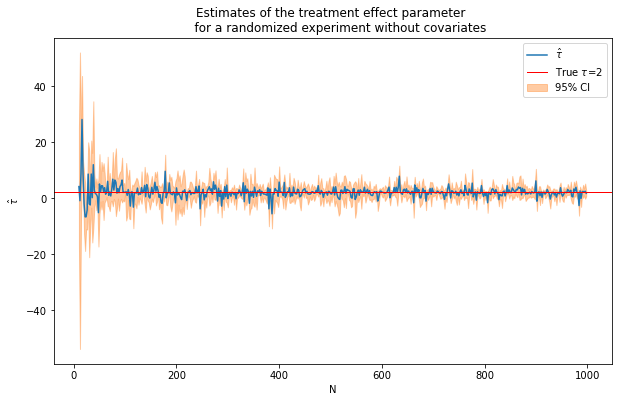

In [291]:
tau = 2
sB_mult = 2
corr = .5
#conf=False # hold confounder control constant (as in we control for the confounder in both cases)
flagX=False # don't control for covariates
sBias=True # same here, control for selection bias in both cases
p = 10
p0 = 2 # number of covariates used in the DGP

Nrange = range(10,1000,2) # loop over N values
(nvalues,tauhats,sehats,lb,ub) = fn_run_experiments(tau,sB_mult,sBias,Nrange,p,p0,corr,conf,flagX)
caption = """Estimates of the treatment effect parameter 
    for a randomized experiment without covariates"""
fn_plot_with_ci(nvalues,tauhats,tau,lb,ub,caption)

ii. Illustrate your DGP with a DAG

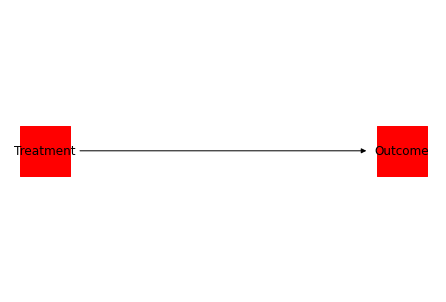

In [292]:
triangle_graph = nx.from_edgelist([('Treatment','Outcome')], create_using=nx.DiGraph)

nx.draw_planar(triangle_graph,
              with_labels=True,
              node_size=2500,
              node_color='#FF0000',
              node_shape='s')

iii. Show, using a Monte Carlo experiment with sample sizes N=100 and N=1000, what the bias,
RMSE and size of your treatment effect estimate is in case a.

In [309]:
tau = 2
sB_mult = 2
corr = .5
#conf=False # hold confounder control constant (as in we control for the confounder in both cases)
flagX=False # don't control for covariates
sBias=True # same here, control for selection bias in both cases
p = 10
p0 = 2 # number of covariates used in the DGP

estDict = {}
R = 2000
for N in [100,1000]:
    Ylist = []
    Tlist = []
    Slist = []
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        # don't control for covariates, do control for mediator variable
        Yexp,T,S = fn_generate_data(tau,sB_mult,N,p,p0,corr,sBias,conf,flagX)
        Ylist.append(Yexp)
        Tlist.append(T)
        Slist.append(S)
        Yt = Yexp[np.where((T==1) & (S==1))[0],:]
        Yc = Yexp[np.where((T==0) & (S==1))[0],:]
        tauhat,sehat = fn_tauhat_means(Yt,Yc)
        tauhats = tauhats + [tauhat]
        sehats = sehats + [sehat]
    data = pd.DataFrame({'Y':Ylist,
                'T':Tlist,
                'S':Slist})
    data.to_csv('noCovariates'+str(N)+'.csv')
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }


    
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

100%|███████████████████████████████████████| 2000/2000 [00:31<00:00, 63.84it/s]


N=100: bias=0.08371463830565114, RMSE=3.201945451537458, size=0.061
N=1000: bias=0.028111880069981523, RMSE=1.0116907302321245, size=0.0525


b. You control for all the covariates that affect the outcome

i. Simulate a DGP

100%|████████████████████████████████████████| 495/495 [00:03<00:00, 140.55it/s]


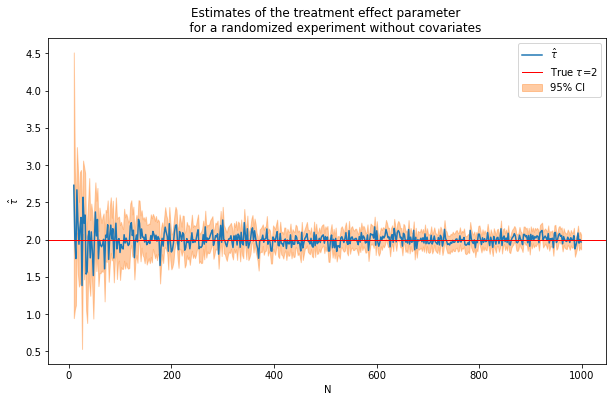

In [294]:
tau = 2
sB_mult = 2
corr = .5
#conf=False # hold confounder control constant (as in we control for the confounder in both cases)
flagX=True # control for covariates
sBias=True # same here, control for selection bias in both cases
p = 10
p0 = 2 # number of covariates used in the DGP

Nrange = range(10,1000,2) # loop over N values
(nvalues,tauhats,sehats,lb,ub) = fn_run_experiments(tau,sB_mult,sBias,Nrange,p,p0,corr,conf,flagX)
caption = """Estimates of the treatment effect parameter 
    for a randomized experiment without covariates"""
fn_plot_with_ci(nvalues,tauhats,tau,lb,ub,caption)

ii. Illustrate your DGP with a DAG

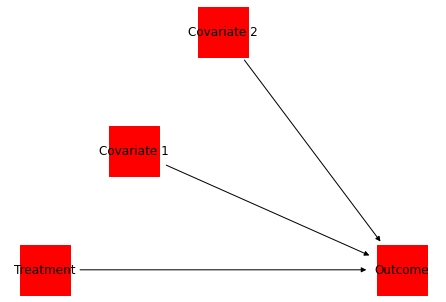

In [295]:
triangle_graph = nx.from_edgelist([('Treatment','Outcome'),
                                  ('Covariate 1','Outcome'),
                                  ('Covariate 2','Outcome')], create_using=nx.DiGraph)

nx.draw_planar(triangle_graph,
              with_labels=True,
              node_size=2500,
              node_color='#FF0000',
              node_shape='s')

iii. Show, using a Monte Carlo experiment with sample sizes N=100 and N=1000, what the bias,
RMSE and size of your treatment effect estimate is in case b.

In [296]:
tau = 2
sB_mult = 2
corr = .5
#conf=False # hold confounder control constant (as in we control for the confounder in both cases)
flagX=True # control for covariates
sBias=True # same here, control for selection bias in both cases
p = 10
p0 = 2 # number of covariates used in the DGP

Ylist = []
Tlist = []
Slist = []
Xlist = []

estDict = {}
R = 2000
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        # control for both covariates and mediator variable
        Yexp,T,X,S = fn_generate_data(tau,sB_mult,N,p,p0,corr,sBias,conf,flagX)
        Ylist.append(Yexp)
        Tlist.append(T)
        Slist.append(S)
        Xlist.append(X)
        Xobs = X[:,:p0]
        covars = np.concatenate([T,Xobs,S],axis = 1)
        mod = sm.OLS(Yexp,covars)
        res = mod.fit()
        tauhat = res.params[0]
        sehat = res.HC1_se[0]
        tauhats = tauhats + [tauhat]
        sehats = sehats + [sehat]
    data = pd.DataFrame({'Y':Ylist,
                'T':Tlist,
                'S':Slist,
                'X':Xlist})
    data.to_csv('withCovariates'+str(N)+'.csv')
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')


100%|███████████████████████████████████████| 2000/2000 [00:32<00:00, 61.82it/s]

N=100: bias=-0.0028502280686614734, RMSE=0.16486256770189395, size=0.0545
N=1000: bias=3.386055129529908e-05, RMSE=0.052354320002859986, size=0.0545


iv. Give an example of a real-life situation that might be consistent with the DGP.

An example of a real-life situation that might be consistent with this situation can be seen with the following DAG:

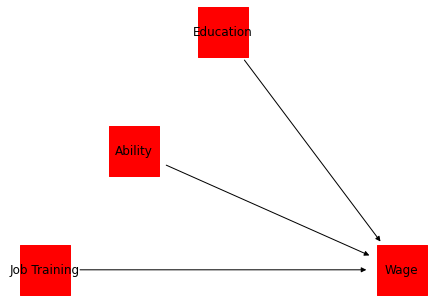

In [297]:
triangle_graph = nx.from_edgelist([('Job Training','Wage'),
                                  ('Ability','Wage'),
                                  ('Education','Wage')], create_using=nx.DiGraph)

nx.draw_planar(triangle_graph,
              with_labels=True,
              node_size=2500,
              node_color='#FF0000',
              node_shape='s')

where Job Training is the treatment variable, Wage is the outcome, and Ability and Education Level are two covariates unassociated with the randomly assigned Job Training.

# Option 2:

Simulate a DGP with a confounder (common cause)

a. You fail to control for the confounder

i. Simulate a DGP

100%|█████████████████████████████████████████| 495/495 [00:05<00:00, 97.14it/s]


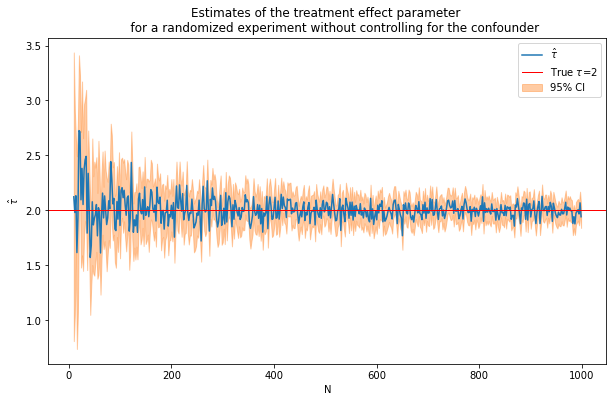

In [299]:
tau = 2
sB_mult = 2
corr = .5
conf=False # don't control for confounder in this case
flagX=True # control for covariates in both cases
sBias=True # same here, control for selection bias in both cases
p = 10
p0 = 2 # number of covariates used in the DGP

Nrange = range(10,1000,2) # loop over N values
(nvalues,tauhats,sehats,lb,ub) = fn_run_experiments(tau,sB_mult,sBias,Nrange,p,p0,corr,conf,flagX)
caption = """Estimates of the treatment effect parameter 
    for a randomized experiment without controlling for the confounder"""
fn_plot_with_ci(nvalues,tauhats,tau,lb,ub,caption)

ii. Illustrate your DGP with a DAG

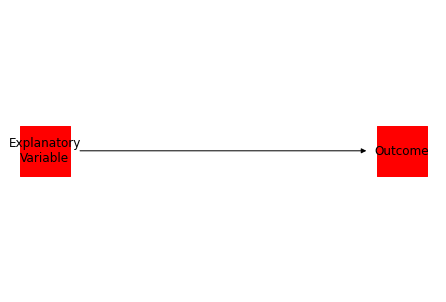

In [300]:
triangle_graph = nx.from_edgelist([('Explanatory\nVariable','Outcome')], create_using=nx.DiGraph)

nx.draw_planar(triangle_graph,
              with_labels=True,
              node_size=2500,
              node_color='#FF0000',
              node_shape='s')

iii. Show, using a Monte Carlo experiment with sample sizes N=100 and N=1000, what the bias,
RMSE and size of your treatment effect estimate is in case a.

In [301]:
tau = 2
sB_mult = 2
corr = .5
conf=False # don't control for confounder in this case
flagX=True # control for covariates in both cases
sBias=True # same here, control for selection bias in both cases
p = 10
p0 = 2 # number of covariates used in the DGP

Ylist = []
Tlist = []
Slist = []
Xlist = []

estDict = {}
R = 2000
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        # control for both covariates and mediator variable
        Yexp,T,X,S = fn_generate_data(tau,sB_mult,N,p,p0,corr,sBias,conf,flagX)
        Ylist.append(Yexp)
        Tlist.append(T)
        Slist.append(S)
        Xlist.append(X)
        Xobs = X[:,:p0]
        covars = np.concatenate([T,Xobs,S],axis = 1)
        mod = sm.OLS(Yexp,covars)
        res = mod.fit()
        tauhat = res.params[0]
        sehat = res.HC1_se[0]
        tauhats = tauhats + [tauhat]
        sehats = sehats + [sehat]
    data = pd.DataFrame({'Y':Ylist,
                        'T':Tlist,
                        'S':Slist,
                        'X':Xlist})
    data.to_csv('noConfounder'+str(N)+'.csv')
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

100%|███████████████████████████████████████| 2000/2000 [00:32<00:00, 62.14it/s]

N=100: bias=0.002068393442178516, RMSE=0.16589601358122416, size=0.0585
N=1000: bias=-0.0010505860050160256, RMSE=0.05272999891812499, size=0.048


b. You do control for the confounder

i. Simulate a DGP

100%|████████████████████████████████████████| 495/495 [00:02<00:00, 166.03it/s]


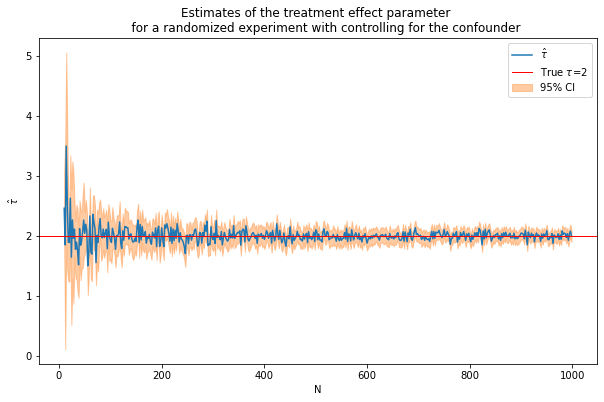

In [302]:
tau = 2
sB_mult = 2
corr = .5
#conf=False # control for confounder in this case
flagX=True # control for covariates in both cases
sBias=True # same here, control for selection bias in both cases
p = 10
p0 = 2 # number of covariates used in the DGP

Nrange = range(10,1000,2) # loop over N values
(nvalues,tauhats,sehats,lb,ub) = fn_run_experiments(tau,sB_mult,sBias,Nrange,p,p0,corr,conf,flagX)
caption = """Estimates of the treatment effect parameter 
    for a randomized experiment with controlling for the confounder"""
fn_plot_with_ci(nvalues,tauhats,tau,lb,ub,caption)

ii. Illustrate your DGP with a DAG

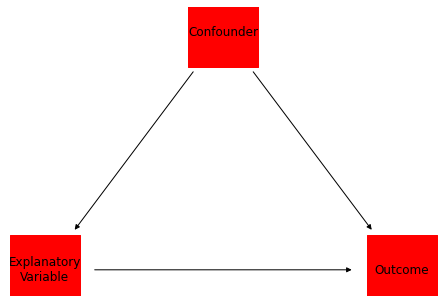

In [273]:
triangle_graph = nx.from_edgelist([('Explanatory\nVariable','Outcome'),
                                  ('Confounder','Outcome'),
                                  ('Confounder','Explanatory\nVariable')], create_using=nx.DiGraph)

nx.draw_planar(triangle_graph,
              with_labels=True,
              node_size=5000,
              node_color='#FF0000',
              node_shape='s')

iii. Show, using a Monte Carlo experiment with sample sizes N=100 and N=1000, what the bias,
RMSE and size of your treatment effect estimate is in case b.

In [303]:
tau = 2
sB_mult = 2
corr = .5
#conf=False # control for confounder in this case
flagX=True # control for covariates in both cases
sBias=True # same here, control for selection bias in both cases
p = 10
p0 = 2 # number of covariates used in the DGP

Ylist = []
Tlist = []
Slist = []
Xlist = []

estDict = {}
R = 2000
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        # control for both covariates and mediator variable
        Yexp,T,X,S = fn_generate_data(tau,sB_mult,N,p,p0,corr,sBias,conf,flagX)
        Ylist.append(Yexp)
        Tlist.append(T)
        Slist.append(S)
        Xlist.append(X)
        Xobs = X[:,:p0]
        covars = np.concatenate([T,Xobs,S],axis = 1)
        mod = sm.OLS(Yexp,covars)
        res = mod.fit()
        tauhat = res.params[0]
        sehat = res.HC1_se[0]
        tauhats = tauhats + [tauhat]
        sehats = sehats + [sehat]
    data = pd.DataFrame({'Y':Ylist,
                        'T':Tlist,
                        'S':Slist,
                        'X':Xlist})
    data.to_csv('withConfounder'+str(N)+'.csv')
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

100%|███████████████████████████████████████| 2000/2000 [00:31<00:00, 63.25it/s]

N=100: bias=-0.00037154799319014575, RMSE=0.16411813405523834, size=0.0525
N=1000: bias=7.653329996663105e-05, RMSE=0.04933672811869824, size=0.037


iv. Give an example of a real-life situation that might be consistent with the DGP.

An example of a real-life situation that might be consistent with this situation can be seen with the following DAG:

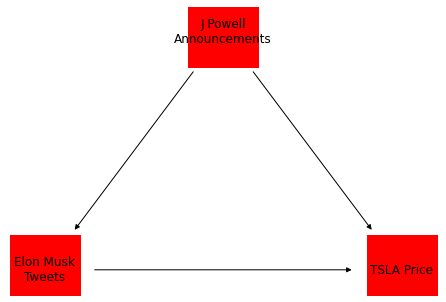

In [277]:
triangle_graph = nx.from_edgelist([('Elon Musk\nTweets','TSLA Price'),
                                  ('J Powell\nAnnouncements','TSLA Price'),
                                  ('J Powell\nAnnouncements','Elon Musk\nTweets')], create_using=nx.DiGraph)

nx.draw_planar(triangle_graph,
              with_labels=True,
              node_size=5000,
              node_color='#FF0000',
              node_shape='s')

where Elon Musk Tweets is the variable explaining TSLA Price, but J Powell Announcements (J Powell = Jerome Powell) confounds the effects of Elon Musk Tweets on TSLA Price by affecting both.

# Option 3:

Simulate a DGP with selection bias into the treatment (variable in between the path from the treatment to the outcome)

a. You control for the variable in between the path from cause to effect

i. Simulate a DGP

100%|████████████████████████████████████████| 495/495 [00:03<00:00, 132.02it/s]


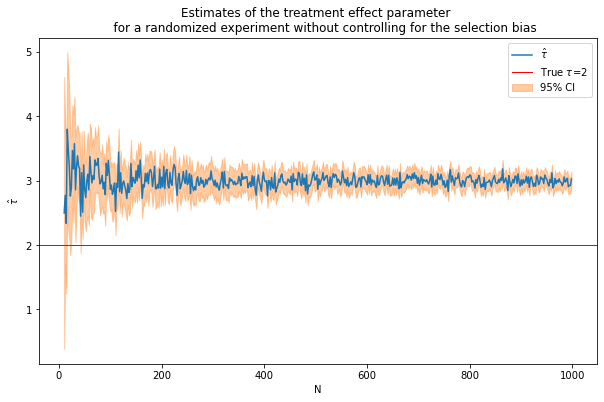

In [278]:
tau = 2
sB_mult = 2
corr = .5
#conf=False # control for confounder in both cases
flagX=True # same here, control for covariates in both cases
sBias=False # don't control for selection bias
p = 10
p0 = 2 # number of covariates used in the DGP

Nrange = range(10,1000,2) # loop over N values
(nvalues,tauhats,sehats,lb,ub) = fn_run_experiments(tau,sB_mult,sBias,Nrange,p,p0,corr,conf,flagX)
caption = """Estimates of the treatment effect parameter 
    for a randomized experiment without controlling for the selection bias"""
fn_plot_with_ci(nvalues,tauhats,tau,lb,ub,caption)

ii. Illustrate your DGP with a DAG

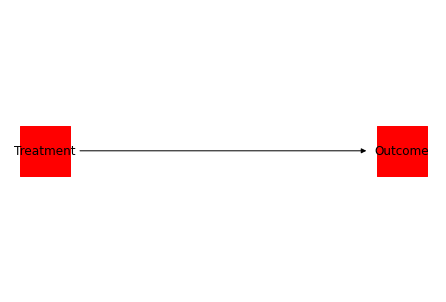

In [279]:
triangle_graph = nx.from_edgelist([('Treatment','Outcome')], create_using=nx.DiGraph)

nx.draw_planar(triangle_graph,
              with_labels=True,
              node_size=2500,
              node_color='#FF0000',
              node_shape='s')

iii. Show, using a Monte Carlo experiment with sample sizes N=100 and N=1000, what the bias,
RMSE and size of your treatment effect estimate is in case a.

In [235]:
tau = 2
sB_mult = 2
corr = .5
#conf=False # control for confounder in both cases
flagX=True # same here, control for covariates in both cases
sBias=False # don't control for selection bias
p = 10
p0 = 40 # number of covariates used in the DGP

Ylist = []
Tlist = []
Xlist = []

estDict = {}
R = 2000
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        # control for both covariates and mediator variable
        Yexp,T,X = fn_generate_data(tau,sB_mult,N,p,p0,corr,sBias,conf,flagX)
        Ylist.append(Yexp)
        Tlist.append(T)
        Xlist.append(X)
        Xobs = X[:,:p0]
        covars = np.concatenate([T,Xobs],axis = 1)
        mod = sm.OLS(Yexp,covars)
        res = mod.fit()
        tauhat = res.params[0]
        sehat = res.HC1_se[0]
        tauhats = tauhats + [tauhat]
        sehats = sehats + [sehat]
    data = pd.DataFrame({'Y':Ylist,
                        'T':Tlist,
                        'X':Xlist})
    data.to_csv('noSelBiasCtrl'+str(N)+'.csv')
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

100%|███████████████████████████████████████| 2000/2000 [00:40<00:00, 48.82it/s]


b. You do not control for the variable in between the path from cause to effect

i. Simulate a DGP

100%|████████████████████████████████████████| 495/495 [00:03<00:00, 138.88it/s]


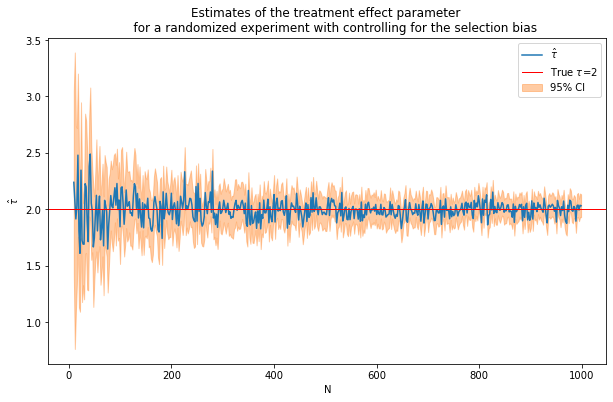

In [280]:
tau = 2
sB_mult = 2
corr = .5
#conf=False # control for confounder in both cases
flagX=True # same here, control for covariates in both cases
sBias=True # control for selection bias
p = 10
p0 = 2 # number of covariates used in the DGP

Nrange = range(10,1000,2) # loop over N values
(nvalues,tauhats,sehats,lb,ub) = fn_run_experiments(tau,sB_mult,sBias,Nrange,p,p0,corr,conf,flagX)
caption = """Estimates of the treatment effect parameter 
    for a randomized experiment with controlling for the selection bias"""
fn_plot_with_ci(nvalues,tauhats,tau,lb,ub,caption)

ii. Illustrate your DGP with a DAG

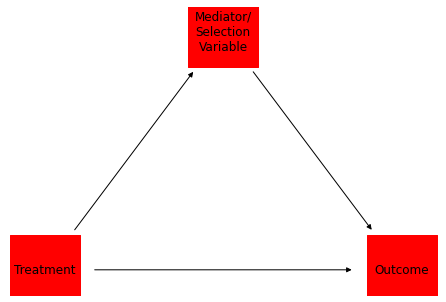

In [288]:
triangle_graph = nx.from_edgelist([('Treatment','Outcome'),
                                  ('Mediator/\nSelection\nVariable','Outcome'),
                                  ('Treatment','Mediator/\nSelection\nVariable')], create_using=nx.DiGraph)

nx.draw_planar(triangle_graph,
              with_labels=True,
              node_size=5000,
              node_color='#FF0000',
              node_shape='s')

iii. Show, using a Monte Carlo experiment with sample sizes N=100 and N=1000, what the bias,
RMSE and size of your treatment effect estimate is in case b.

In [237]:
tau = 2
sB_mult = 2
corr = .5
#conf=False # control for confounder in both cases
flagX=True # same here, control for covariates in both cases
sBias=True # control for selection bias
p = 10
p0 = 2 # number of covariates used in the DGP

Ylist = []
Tlist = []
Slist = []
Xlist = []

estDict = {}
R = 2000
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        # control for both covariates and mediator variable
        Yexp,T,X,S = fn_generate_data(tau,sB_mult,N,p,p0,corr,sBias,conf,flagX)
        Ylist.append(Yexp)
        Tlist.append(T)
        Slist.append(S)
        Xlist.append(X)
        Xobs = X[:,:p0]
        covars = np.concatenate([T,Xobs,S],axis = 1)
        mod = sm.OLS(Yexp,covars)
        res = mod.fit()
        tauhat = res.params[0]
        sehat = res.HC1_se[0]
        tauhats = tauhats + [tauhat]
        sehats = sehats + [sehat]
    data = pd.DataFrame({'Y':Ylist,
                        'T':Tlist,
                        'S':Slist,
                        'X':Xlist})
    data.to_csv('withSelBiasCtrl'+str(N)+'.csv')
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

100%|███████████████████████████████████████| 2000/2000 [00:40<00:00, 49.91it/s]


iv. Give an example of a real-life situation that might be consistent with the DGP.

An example of a real-life situation that might be consistent with this situation can be seen with the following DAG:

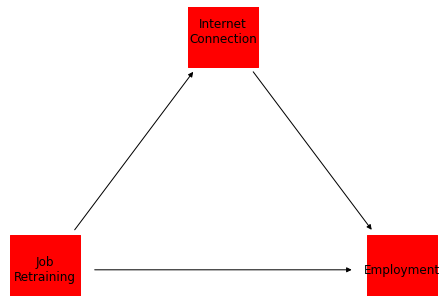

In [285]:
triangle_graph = nx.from_edgelist([('Job\nRetraining','Employment'),
                                  ('Internet\nConnection','Employment'),
                                  ('Job\nRetraining','Internet\nConnection')], create_using=nx.DiGraph)

nx.draw_planar(triangle_graph,
              with_labels=True,
              node_size=5000,
              node_color='#FF0000',
              node_shape='s')

where our treatment variable is a Job Retraining program offered by the government, and perhaps it is advertised through the Internet, leading to selection to the program being affected by people's Internet Connection. This could lead to bias in the estimation of the effect of the Job Retraining program on levels of Employment, our outcome variable.